<a href="https://colab.research.google.com/github/aishwaryatiwari/MachineLearning/blob/main/DataQuest_Guided_Project_Predicting_Car_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
# Import libraries as needed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from  matplotlib import pyplot as plt
import seaborn
seaborn.set(style='ticks')

In [72]:
# Reading in the cars dataset into a pandas dataframe from the given URL
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data')
# The data does not come with headers. Assigning headers explicitly
cars.columns = ['symboling','normalized_losses','make','fuel_type',	'aspiration',	'num_doors',	'body_style',	'drive_wheels',	'engine_location',\
                'wheel_base',	'length',	'width',	'height',	'curb_weight',	'engine_type',	'num_cylinders',	'engine_size',	'fuel_system',	'bore',\
                'stroke',	'compression_ratio',	'horsepower',	'peak_rpm',	'city_mpg',	'highway_mpg',	'price']
#cars.info()
cars.head(4)

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [73]:
# Replacing '?' values with NAN. We will eventually need to remove all rows where cells used in the model have missing values
cars = cars.replace('?', np.nan)

# Correcting datatypes to ensure int and float columns are not represented as objects
cars = cars.astype({'normalized_losses':'float', 'bore':'float', 'stroke':'float', 'horsepower':'float', 'peak_rpm':'float', 'price':'float'})
# Check updated datatypes
# cars.dtypes

# 40 out of 204, i.e. 20% records have missing values for normalized losses. We need to explore the best strategy to handle these cases
print('All Records - ', cars.shape, 'Records with null normalized losses - ', np.isnan(cars.normalized_losses).sum())

# Exploring the values of other columns where normalized losses is null - 
cars.loc[cars['normalized_losses'].isnull()].isna().sum()

All Records -  (204, 26) Records with null normalized losses -  40


symboling             0
normalized_losses    40
make                  0
fuel_type             0
aspiration            0
num_doors             1
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
num_cylinders         0
engine_size           0
fuel_system           0
bore                  0
stroke                0
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

In [74]:
print('All records - ', cars.shape)
# Removing records from the dataframe where normalized losses and price is null - 
cars = cars.loc[~((cars.normalized_losses.isnull()) & (cars.price.isnull()))]
print('Records after removing rows with null price column - ', cars.shape)

# Few rows have other columns as null, alongwith normalized_losses being null. These are removed as well - 
cars = cars.loc[~((cars.normalized_losses.isnull()) & ((cars.num_doors.isnull()) | (cars.horsepower.isnull()) | (cars.peak_rpm.isnull())))]
cars = cars.loc[~((cars.bore.isnull()) | (cars.stroke.isnull()))]
print('Records after removing rows with other null columns - ', cars.shape)

# Removing Object-type columns from the dataframe
cars = cars.drop(columns={'make','fuel_type', 'aspiration', 'num_doors', 'body_style', 'drive_wheels', 'engine_location', 'engine_type',\
                          'num_cylinders','fuel_system'})
print('Records after removing columns with Object datatype - ', cars.shape)

All records -  (204, 26)
Records after removing rows with null price column -  (200, 26)
Records after removing rows with other null columns -  (193, 26)
Records after removing columns with Object datatype -  (193, 16)


In [77]:
# Proportionally large number of rows have null values for normalized losses. Setting the normalized losses column to the mean value of the column
cars.loc[cars['normalized_losses'].isnull(), 'normalized_losses'] = cars.normalized_losses.mean()

# Validate to see that no columns should have any null values now - 
# cars.loc[cars['normalized_losses'].isnull()].isna().sum()

# After the row deletions above, reseting index to be sequential again
cars = cars.reset_index().drop(columns='index')
cars.head(2)

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,121.3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
1,1,121.3,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0


In [58]:
# There can be many ways of normalization. One being Mean-normalization. This results in a mean of 0 and standard deviation of 0 for the numeric values
# in the dataframe and can be achieved as follows - cars_norm = (cars - cars.mean())/cars.std()
# Another method can be getting the values to fall between 0 and 1 as follows - 
cars_norm = (cars - cars.min())/(cars.max()-cars.min())
# Set price column back to the original price values
cars_norm['price'] = cars['price']
cars_norm.head()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,1.0,0.294764,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.12500,0.294393,0.346939,0.222222,0.289474,16500.0
1,0.6,0.294764,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.12500,0.495327,0.346939,0.166667,0.263158,16500.0
2,0.8,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.18750,0.252336,0.551020,0.305556,0.368421,13950.0
3,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.06250,0.313084,0.551020,0.138889,0.157895,17450.0
4,0.8,0.294764,0.384840,0.540299,0.512821,0.441667,0.395268,0.283019,0.464286,0.633333,0.09375,0.289720,0.551020,0.166667,0.236842,15250.0


In [82]:
def knn_train_test(train_col, tgt_col, df):
  cars_train, cars_test = train_test_split(df, test_size=0.3, random_state=1)
  knn = KNeighborsRegressor(algorithm='brute')
  knn.fit(cars_train[[train_col]], cars_train[tgt_col])
  price_predictions = knn.predict(cars_test[[train_col]])
  rmse = mean_squared_error(cars_test[[train_col]], price_predictions) ** (1/2)
  return rmse

In [83]:
all_col = cars_norm.columns
all_col = all_col.drop(['price'])
#print(all_col)

col_rmse = dict()
for col in all_col:
  col_rmse[col] = knn_train_test(col, 'price', cars_norm)

print(col_rmse)

{'symboling': 11357.32805175462, 'normalized_losses': 13957.798456901886, 'wheel_base': 14347.081024554673, 'length': 14049.18119008101, 'width': 14493.414991259962, 'height': 11890.660101680987, 'curb_weight': 14102.506352348182, 'engine_size': 14323.038880446225, 'bore': 13335.937892190825, 'stroke': 12890.934207457842, 'compression_ratio': 15487.334282394044, 'horsepower': 15425.914789685761, 'peak_rpm': 14847.926857193723, 'city_mpg': 13450.611444210179, 'highway_mpg': 12816.994829863483}


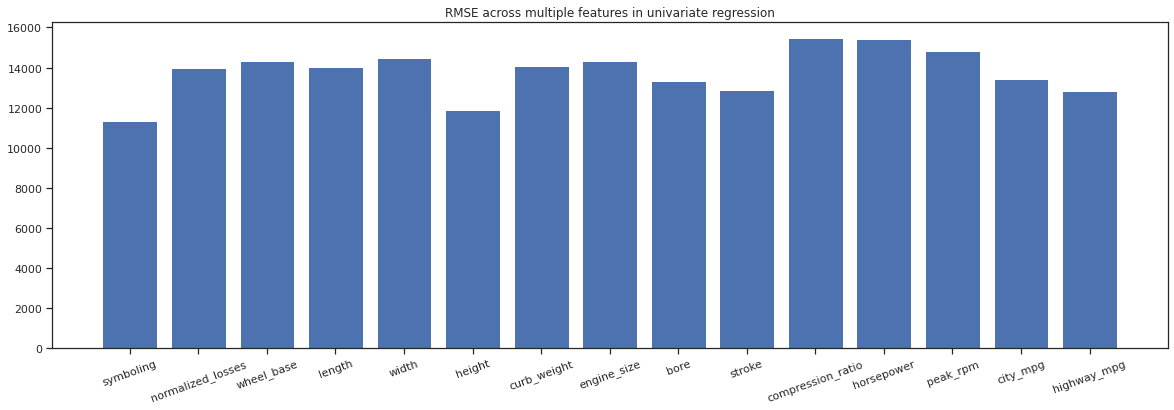

In [136]:
plt.figure(figsize=(20,6))
plt.bar(range(len(col_rmse)), list(col_rmse.values()), align='center')
plt.xticks(range(len(col_rmse)), list(col_rmse.keys()), rotation=20)
plt.title('RMSE across multiple features in univariate regression')
plt.show()

In [84]:
min_rmse_value = min(col_rmse.values())
min_rmse_col = [key for key in col_rmse.keys() if col_rmse[key] == min(col_rmse.values())]

print('For univariate regression with default k = 5, we get the minimum error of ', min_rmse_value, 'in price predictions for -', min_rmse_col)

For univariate regression with default k = 5, we get the minimum error of  11357.32805175462 in price predictions for - ['symboling']


In [85]:
# Modifiying the univariate regression function we created above to include k-value as a hyperparameter
def knn_train_test_variable_k(train_col, tgt_col, df, k):
  cars_train, cars_test = train_test_split(df, test_size=0.3, random_state=1)
  knn = KNeighborsRegressor(algorithm='brute', n_neighbors=k)
  knn.fit(cars_train[[train_col]], cars_train[tgt_col])
  price_predictions = knn.predict(cars_test[[train_col]])
  rmse = mean_squared_error(cars_test[[train_col]], price_predictions) ** (1/2)
  return rmse

In [86]:
# Re-running the univariate regression function, with the new hyperparameter values 
col_rmse_k = []
k_val = [1,3,5,7,9]
for col in all_col:
  for k in k_val:
    col_rmse_k.append([col, k, knn_train_test_variable_k(col, 'price', cars_norm,k)])

#print(col_rmse_k)

# Converting the list above into a dataframe for ease of analysis and plotting -
col_rmse_k_df = pd.DataFrame(col_rmse_k)
col_rmse_k_df.columns=['col', 'k_val', 'rmse']
print(col_rmse_k_df.shape)
print(col_rmse_k_df.head(2))

(75, 3)
         col  k_val          rmse
0  symboling      1  18815.299033
1  symboling      3  14557.875534


The following scatter plot shows us how varying the hyperparameter, i.e. the number of neighbors analyzed for univariate regression, affects the error in price predictions across many possible features impacting the price of a car.

With the default k value of 5, the variable length appears to be the most promising feature, giving the minimum error. Symboling shows as the least promising feature, with consistently high error values across multiple hyperparameters.

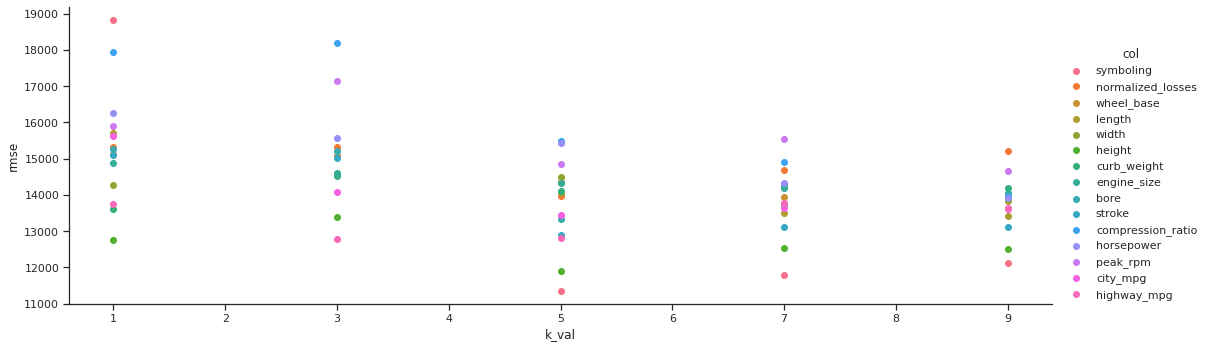

In [135]:
fg = seaborn.FacetGrid(data=col_rmse_k_df, hue='col', aspect=3, height=5)
fg.map(pyplot.scatter, 'k_val', 'rmse').add_legend()

In [88]:
# Modifiying the regression function we created above to accept multiple feature columns to predict the car price. 
# Here we are using the default k-value of 5
def knn_train_test_multi(train_cols, tgt_col, df):
  cars_train, cars_test = train_test_split(df, test_size=0.3, random_state=1)
  knn = KNeighborsRegressor(algorithm='brute')
  knn.fit(cars_train[train_cols], cars_train[tgt_col])
  price_predictions = knn.predict(cars_test[train_cols])
  rmse = mean_squared_error(cars_test[tgt_col], price_predictions) ** (1/2)
  return rmse

Observing the scatter plot above, we see some features perform better in predicting price than others in the univariate model. We now use multiple columns to predict the prices and see how the error value changes. 

In [94]:
cols_2 = col_rmse_k_df.loc[col_rmse_k_df['k_val']==5].sort_values(by=['rmse'], ascending=True)[:2]['col']
multi_rmse_2 = knn_train_test_multi(cols_2, 'price', cars_norm)

cols_3 = col_rmse_k_df.loc[col_rmse_k_df['k_val']==5].sort_values(by=['rmse'], ascending=True)[:3]['col']
multi_rmse_3 = knn_train_test_multi(cols_3, 'price', cars_norm)

cols_4 = col_rmse_k_df.loc[col_rmse_k_df['k_val']==5].sort_values(by=['rmse'], ascending=True)[:4]['col']
multi_rmse_4 = knn_train_test_multi(cols_4, 'price', cars_norm)

cols_5 = col_rmse_k_df.loc[col_rmse_k_df['k_val']==5].sort_values(by=['rmse'], ascending=True)[:5]['col']
multi_rmse_5 = knn_train_test_multi(cols_5, 'price', cars_norm)

print('Multivariate regression results with default k-value of 5 - ')
print('',cols_2.values, multi_rmse_2, '\n',cols_3.values, multi_rmse_3, '\n', cols_4.values, multi_rmse_4, '\n', cols_5.values, multi_rmse_5)

Multivariate regression results with default k-value of 5 - 
 ['symboling' 'height'] 7115.430320812989 
 ['symboling' 'height' 'highway_mpg'] 5505.484830101956 
 ['symboling' 'height' 'highway_mpg' 'stroke'] 4559.223216960205 
 ['symboling' 'height' 'highway_mpg' 'stroke' 'bore'] 4211.766047797445


The above multi-variate models were tested using the default neighbors value of 5. We now test optimizing the hyperparameter of neighbors to see if we can reduce the rmse error value further. 
For this, we pick the features that performed best in the above test - length and normalized losses. 

In [68]:
# Modifiying the multi-variate regression function we created above to accept a hyperparameter in place of using the default value of 5
# to predict the car price. 
def knn_train_test_hyp(train_cols, tgt_col, df, k_n):
  cars_train, cars_test = train_test_split(df, test_size=0.3, random_state=1)
  knn = KNeighborsRegressor(algorithm='brute', n_neighbors=k_n)
  knn.fit(cars_train[train_cols], cars_train[tgt_col])
  price_predictions = knn.predict(cars_test[train_cols])
  rmse = mean_squared_error(cars_test[tgt_col], price_predictions) ** (1/2)
  return rmse

In [95]:
k_val_list = [x for x in range(1,26)]
col_rmse_k_list_1 = []
col_rmse_k_list_2 = []
col_rmse_k_list_3 = []
for k in k_val_list:
  col_rmse_k_list_1.append([k, knn_train_test_hyp(['symboling', 'height', 'highway_mpg', 'stroke', 'bore'], 'price', cars_norm,k)])
  col_rmse_k_list_2.append([k, knn_train_test_hyp(['symboling', 'height', 'highway_mpg', 'stroke'], 'price', cars_norm,k)])
  col_rmse_k_list_3.append([k, knn_train_test_hyp(['symboling', 'height', 'highway_mpg'], 'price', cars_norm,k)])

print(col_rmse_k_list)

col_rmse_k_df_1 = pd.DataFrame(col_rmse_k_list_1, columns=['n_neighbors', 'rmse'])
col_rmse_k_df_1.index = col_rmse_k_df_1['n_neighbors']

col_rmse_k_df_2 = pd.DataFrame(col_rmse_k_list_2, columns=['n_neighbors', 'rmse'])
col_rmse_k_df_2.index = col_rmse_k_df_2['n_neighbors']

col_rmse_k_df_3 = pd.DataFrame(col_rmse_k_list_3, columns=['n_neighbors', 'rmse'])
col_rmse_k_df_3.index = col_rmse_k_df_3['n_neighbors']
print(col_rmse_k_df_1.head(2))

[[1, 4400.608054283258], [2, 4006.536363102921], [3, 4661.508403349899], [4, 5002.350461128609], [5, 5241.64522055283], [6, 5303.339479883302], [7, 5361.094667890245], [8, 5496.8179750504405], [9, 5595.930154894713], [10, 5702.496033416773], [11, 5665.673345391126], [12, 5655.78794386468], [13, 5581.781280560457], [14, 5529.5692150024715], [15, 5436.789482761176], [16, 5398.034284194203], [17, 5441.93122354562], [18, 5432.401239011867], [19, 5474.29018286101], [20, 5515.338057593213], [21, 5523.004343346377], [22, 5534.8056689198065], [23, 5534.488546466807], [24, 5560.181471697681], [25, 5611.444412337947]]
             n_neighbors         rmse
n_neighbors                          
1                      1  5948.955887
2                      2  5049.486183


Varying hyperparameter 'k' shows that the error value declines at first with increasing the number of neighbors analyzed, then sharply increases, indicating analyzing more neighbors is not a guarantee of less error in predictions.

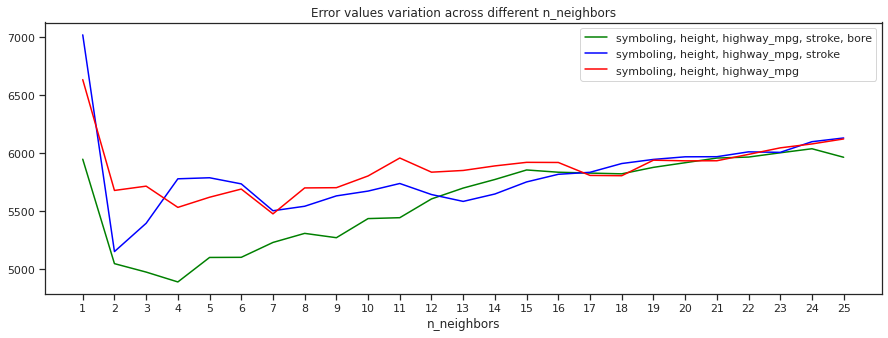

In [133]:
plt.figure(figsize=(15,5))
col_rmse_k_df_1['rmse'].plot.line(color='green', label="symboling, height, highway_mpg, stroke, bore")
col_rmse_k_df_2['rmse'].plot.line(color='blue', label = "symboling, height, highway_mpg, stroke")
col_rmse_k_df_3['rmse'].plot.line(color='red', label = "symboling, height, highway_mpg")
plt.xticks(range(1, 26))
plt.title('Error values variation across different n_neighbors')
plt.legend()
plt.show()

K-Fold

In [111]:
def knn_train_test_kfold(train_cols, tgt_col, df, n_splt):
  kf = KFold(n_splits=n_splt, shuffle=True, random_state=1)
  knn = KNeighborsRegressor(algorithm='brute')
  mses = cross_val_score(knn, df[train_cols], df[tgt_col],\
                         scoring='neg_mean_squared_error', cv=kf)
  rmses = [(abs(x))**(1/2) for x in mses]
  return [n_splt, np.mean(rmses), np.std(rmses)]

In [118]:
n_splits = [x for x in range(2, 21)]
k_fold_metrics = []
for n in n_splits:
  k_fold_metrics.append(knn_train_test_kfold(['symboling', 'height', 'highway_mpg', 'stroke', 'bore'], 'price', cars_norm, n))

k_fold_metrics_df = pd.DataFrame(k_fold_metrics, columns=['k_fold', 'mean', 'std'])
k_fold_metrics_df.index = k_fold_metrics_df['k_fold']

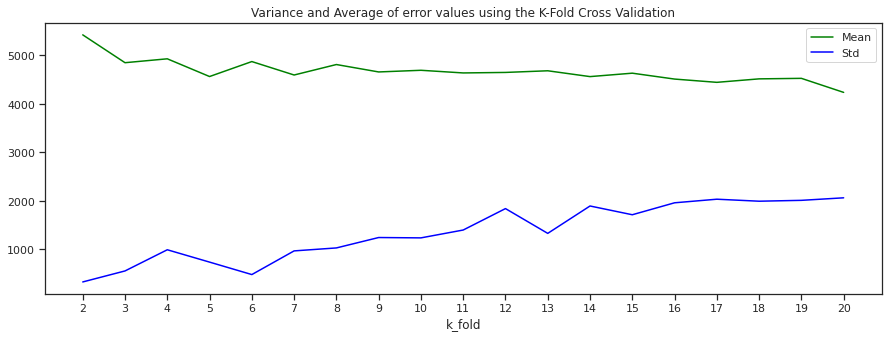

In [130]:
plt.figure(figsize=(15,5))
k_fold_metrics_df['mean'].plot.line(color='green', label='Mean')
k_fold_metrics_df['std'].plot.line(color='blue', label='Std')
plt.xticks(range(2, 21))
plt.title('Variance and Average of error values using the K-Fold Cross Validation')
plt.legend()
plt.show()